In [1]:
import servo
import analyse
import plot

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def timestamps_to_displacement(timestamped_data, velocity):

    data = (timestamped_data
            .pipe(servo.reindex_timestamps_with_times)
            .pipe(servo.calculate_displacement, velocity)
           )
    displacement_data = data.set_index("Displacement (m)")

    
    return displacement_data
    

def plot_knife_edge_method(ax, dataset):
    xs = dataset.index.values*1E3 # in mm
    ys = dataset["Power (W)"].values*1E6 # in uW
    
    coeffs, coeff_errs = analyse.fit_erf(xs, ys)
    fit_ys = analyse.erf(xs, *coeffs)

    gauss_ys = analyse.G(xs, 2*coeffs[0], coeffs[1], coeffs[2]/np.sqrt(2))

    lower_bound, upper_bound = analyse.get_e_squared_range(xs, gauss_ys)

    ax.set_xlabel("Displacement [mm]")
    
    ax.plot(xs, ys, marker='.', linestyle='', color="tab:blue", label="meas")
    ax.plot(xs, fit_ys,linestyle='--', linewidth=3, color="tab:red", label="erf fit")
    ax.plot(xs, gauss_ys, linestyle='--', linewidth=3, color="tab:purple", label="gauss fit")
    
    plot.draw_dimension_lines(ax, upper_bound, lower_bound)
    ax.vlines(lower_bound, 0, max(ys), linestyle=':', linewidth=2, color="black")
    ax.vlines(upper_bound, 0, max(ys), linestyle=':',  linewidth=2, color="black")

    return upper_bound - lower_bound

def plot_result(files, velocity):
    timestamped_knife_measurements = map(servo.get_data, files)
    displacement_data = map(
        lambda m: timestamps_to_displacement(m, velocity),
        timestamped_knife_measurements
    )
    fig, axes = plt.subplots(len(files),1, dpi=250, sharex=True)

    axes[0].set_ylabel("Power (uW)")
    diameters = np.array([
        plot_knife_edge_method(ax, data) for ax, data in zip(axes, [*displacement_data])
    ])
    mean_diam = diameters.mean()
    mean_diam_err = diameters.std()/np.sqrt(len(diameters))
    fig.suptitle(f"Mean Beam Radius: {round(1E3 * mean_diam/2, 0)} +/- {round(1E3 * mean_diam_err/2, 0)}um")
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncols=3, bbox_to_anchor=(0.1, 0.85, 0.8, 0.1))
    #plt.tight_layout()
    return mean_diam, mean_diam_err




In [5]:
speed_4_data = pd.DataFrame({
    "times": [1.4082, 1.36133, 1.35059, 1.37695, 1.41113, 1.3584, 1.37305, 1.39062, 1.39062, 1.36426, 1.38574, 1.41797, 1.3584, 1.44141, 1.30762, 1.38281, 1.31738, 1.47558, 1.36035, 1.39844, 1.43652, 1.34668, 1.36816, 1.37695, 1.39258, 1.44043, 1.37402, 1.38965, 1.41992, 1.27148, 1.46484, 1.37207, 1.32519, 1.44043, 1.39941],
})

real_speed_4 = pd.DataFrame({
    "times": [1.58887, 1.68945, 1.87402, 1.68164, 1.75781, 1.74805, 1.86328, 1.7793, 1.66016, 1.66406, 1.75879, 1.68848, 1.74805, 1.80371, 1.67773, 1.68066, 1.72656, 1.83008, 1.71387, 1.68555, 1.73926, 1.74707, 1.79004, 1.71973, 1.67871, 1.76367, 1.71875, 1.7959, 1.72461, 1.68164, 1.71484, 1.75, 1.77832, 1.83105, 1.63476, 1.70703, 1.8291]
})


v_4_click_data = pd.read_csv("./Data/speed_4_data.txt", delimiter=",", header=1, usecols=[0,1])
v4 = analyse.get_average_velocity(v_4_click_data)

v = (real_speed_4
              .pipe(analyse.get_std_of_times)
              .pipe(analyse.get_velocity, 200)
              .pipe(analyse.get_velocity_std)
              .pipe(analyse.get_velocity_and_error)
               )

print(f"The accurate value is {v4} compared to {v}")

fake_v = {"value": 0.00014, "error": 0}

The accurate value is {'value': 0.00011178302600162591, 'err': 1.3198377884317171e-06} compared to {'value': 0.00011537195839713835, 'error': 3.642997154522217e-06}


(2.1930041174808648, 0.0060885193713200525)

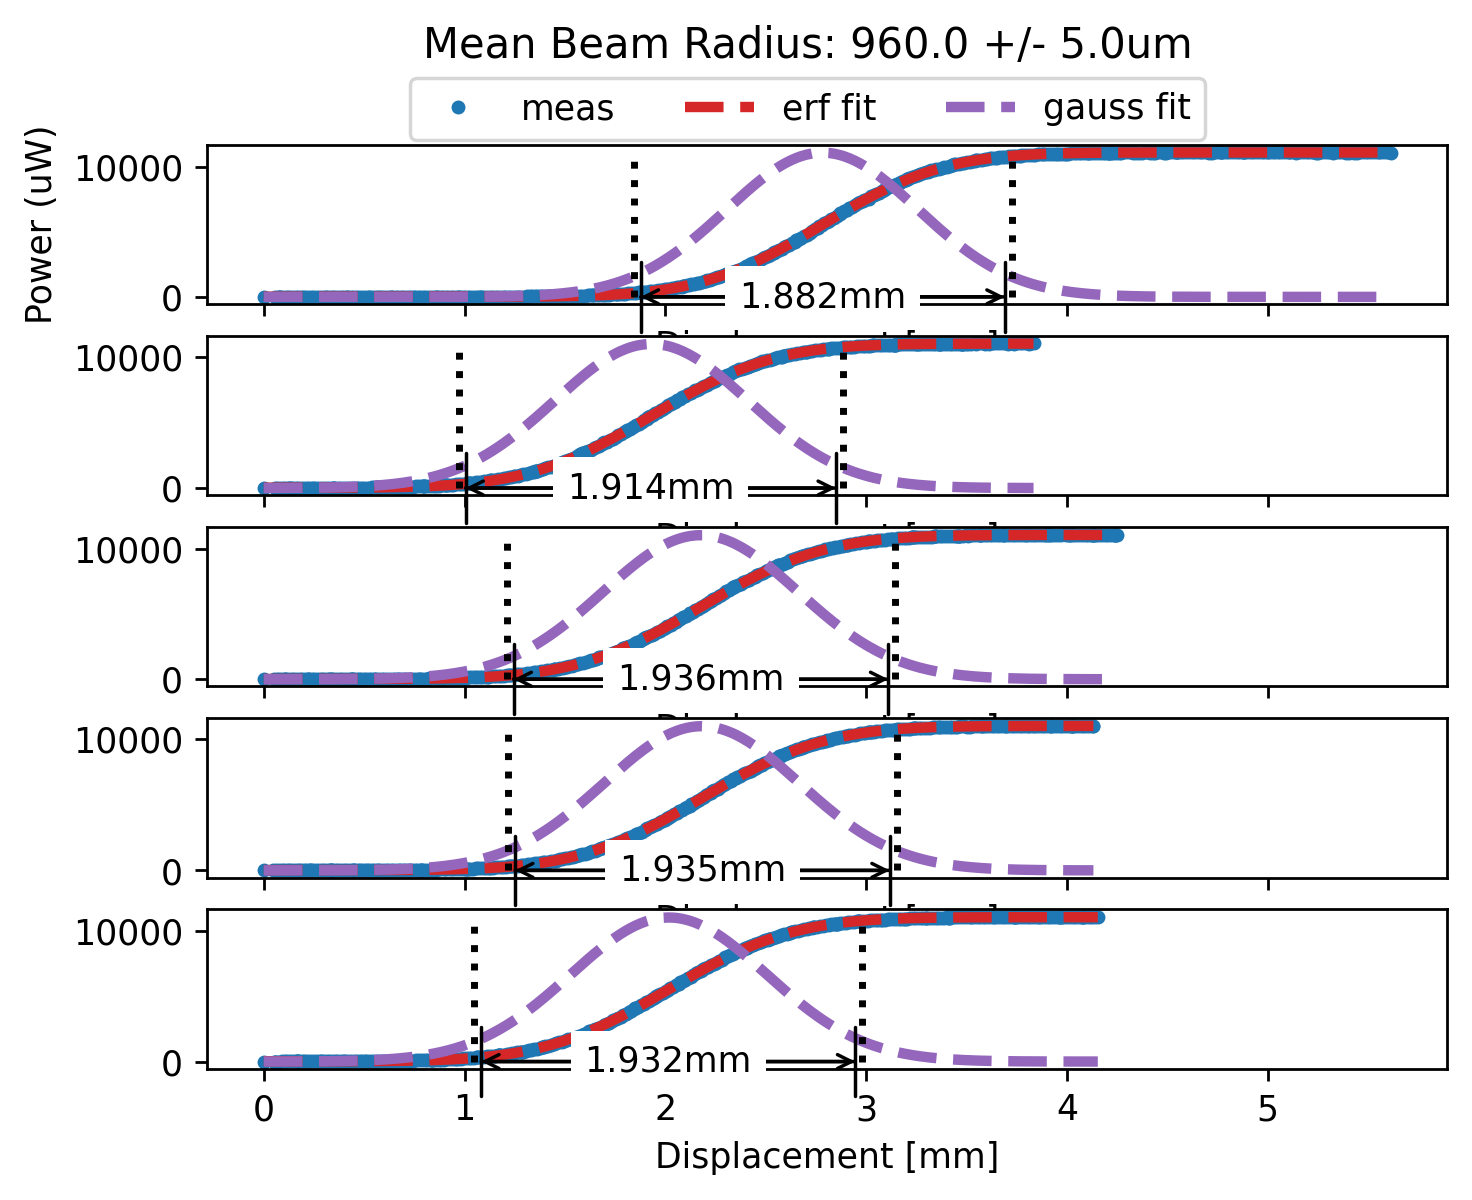

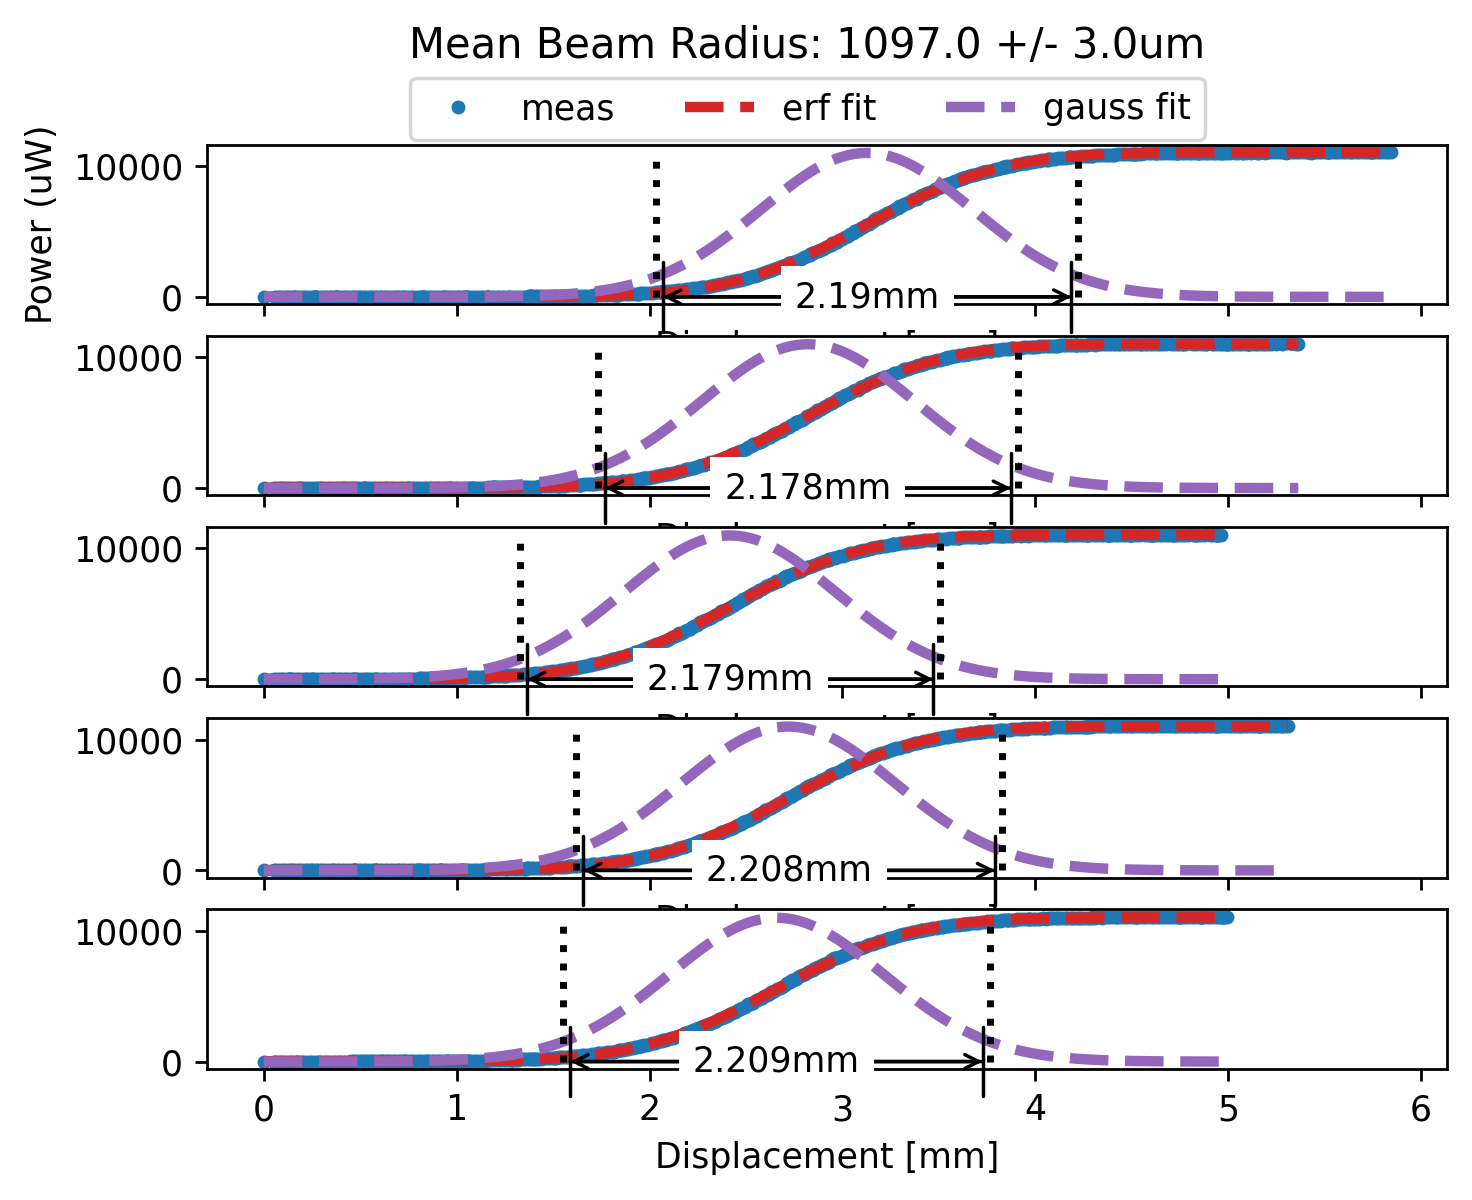

In [7]:
file_PM = [ f"Data/knife-edge/smpm/pm1{l}.csv" for l in "abcde" ]
file_SM = [ f"Data/knife-edge/smpm/sm1{l}.csv" for l in "abcde" ]

plot_result(file_PM, v4)
plot_result(file_SM, v4)

The PM fibre actually has a _smaller_ beam radius that the SM fibre. It clearly makes a difference, however it does not explain the behaviour that I am seeing.